<a id="top"></a>
# NIRISS AMI calibration of WR 137 and calibrator HD228337

<div class="alert alert-block alert-info">
### NOTE: THIS NOTEBOOK IS NOT USING FRAME SELECTION SINCE IT IS WORK IN PROGRESS.

## Introduction
This notebook runs JWST pipeline on Aperture Masking Interferometry(AMI) data of WR137 and calibrator HD228337 observed on August 8, 2022. The sources are observed with the Non-redundant mask (NRM) in the pupil wheel and filters F480M and F380M in the filter wheel and SUB80 array. 

Steps:

[1] Run Detector1 pipeline on all _uncal.fits files to create _rate.fits and _rateints.fits files.

[2] Run Image2 pipeline on all _rate.fits files to create _cal.fits and on _rateints.fits files to
    create _calints.fits files.
    
[3] Run AMI3 pipeline to reduce data calibrated by Detector1 and Image2 pipelines to interferometric observables, extract observables in       oifits format.


*Developer Note:*
Create the conda environment needed to run this notebook by issuing the following command:
```
conda create -n <envname> python=3.11
```

Activate the environment and install dependencies.
```
conda activate <myenv>
pip install -r pre-requirements.txt
pip install -r requirements.txt
```
Contents of pre-requirements.txt
```
numpy==1.23.4
astropy
```
Contents of requirements.txt
```
matplotlib
pyyaml
healpy == 1.16.6
git+https://github.com/spacetelescope/mirage@a813b2f27a863a280a71a542df5a2f5936f5e85a
jwst-gtvt
jwst
webbpsf
stsynphot
uncertainties
munch
astroquery
pandas
termcolor
```


Open the notebook using the following command:

```jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10```

This is needed for the browser to handle the large size of the notebook as it runs and populates output cells.


The requirements.txt file has Mirage version as of August 2nd, 2024. Mirage is used in the simulation notebook and not this notebook. Pipeline version is 1.14.0. Type 'pip freeze' or 'conda list' after activating the conda environment to see version numbers and update when necessary/ as new compatible versions become available.


This installs a specific commit of Mirage
```
- git+https://github.com/spacetelescope/mirage@484b7de446d6fd56c5c462076fb4b7533d5dace6
```

This installs the latest commit on the master branch of Mirage
```
- git+https://github.com/spacetelescope/mirage
```

This installs a released version of Mirage
```
- mirage==2.0.2
```

Added the following as needed.
```
conda install ds9
```

### Do the following steps before running the notebook.

Open the notebook using the following command:
```jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10```

This is needed for the browser to handle the large size of the notebook as it runs and populates output cells.

## Imports
Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *matplotlib.pyplot* for plotting data
- *jwst.pipeline Detector1Pipeline, Image2Pipeline* for calibrating raw data
- *jwst.pipeline AmiAnalyzeStep* to extract raw interferometric observables
- *jwst.pipelineAmiNormalizeStep* to calibrate interferometric observables of the target with that of calibrator

In [1]:
%matplotlib inline
import os
import sys
import glob
import time

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import units as u

from jwst.pipeline import Detector1Pipeline, Image2Pipeline
from jwst.ami import AmiAnalyzeStep
from jwst.ami import AmiNormalizeStep

## Define directory that has raw NRM + Filter data (*_uncal.fits)

In [2]:
currentdir = os.getcwd()

# On orbit data epoch 1
# Only using observations 005 and 006. Observation 003 was affected by mirror tilt event and observation 004 failed to execute.
uncal_dir_epoch1 = os.path.join(currentdir, 'uncal_data_july13_15/')
# On orbit data epoch 2
uncal_dir_epoch2 = os.path.join(currentdir, 'uncal_data_august8/')

uncalfiles_epoch1 = sorted(glob.glob(os.path.join(uncal_dir_epoch1,'jw*uncal.fits')))
uncalfiles_epoch2 = sorted(glob.glob(os.path.join(uncal_dir_epoch2,'jw*uncal.fits')))

uncalfiles = uncalfiles_epoch1 + uncalfiles_epoch2
# uncalfiles = [os.path.basename(i) for i in uncalfiles]
# print uncal.fits file base names with full path
#print('\n'.join(uncalfiles))

# print uncal.fits file base names  
for i in range(len(uncalfiles)): print(os.path.basename(uncalfiles[i]))

jw01349005001_03102_00001_nis_uncal.fits
jw01349005001_03103_00001_nis_uncal.fits
jw01349006001_03102_00001_nis_uncal.fits
jw01349006001_03103_00001_nis_uncal.fits
jw01349053001_03102_00001_nis_uncal.fits
jw01349053001_03102_00002_nis_uncal.fits
jw01349053001_03102_00003_nis_uncal.fits
jw01349053001_03102_00004_nis_uncal.fits
jw01349053001_03104_00001_nis_uncal.fits
jw01349053001_03104_00002_nis_uncal.fits
jw01349053001_03104_00003_nis_uncal.fits
jw01349053001_03104_00004_nis_uncal.fits
jw01349054001_03102_00001_nis_uncal.fits
jw01349054001_03102_00002_nis_uncal.fits
jw01349054001_03102_00003_nis_uncal.fits
jw01349054001_03102_00004_nis_uncal.fits
jw01349054001_03104_00001_nis_uncal.fits
jw01349054001_03104_00002_nis_uncal.fits
jw01349054001_03104_00003_nis_uncal.fits
jw01349054001_03104_00004_nis_uncal.fits


### Information about NRM + Filter exposures from epoch 1 and epoch 2

```
                DISKNAME                           DATE          OBSERVTN    TARGPROP       EXP_TYPE    APERNAME PUPIL FILTER SUBARRAY NGROUPS NINTS PATT_NUM NUMDTHPT
---------------------------------------- ----------------------- -------- -------------- ------------- --------- ----- ------ -------- ------- ----- -------- --------
jw01349005001_03102_00001_nis_uncal.fits 2022-07-15T12:12:59.178      005 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       7  1020        1        1
jw01349005001_03103_00001_nis_uncal.fits 2022-07-15T12:20:57.815      005 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2  2720        1        1
jw01349006001_03102_00001_nis_uncal.fits 2022-07-15T13:37:18.246      006          WR137       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       4  1600        1        4
jw01349006001_03103_00001_nis_uncal.fits 2022-07-15T13:37:17.634      006          WR137       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2  2720        1        4
jw01349053001_03102_00001_nis_uncal.fits 2022-08-09T17:33:05.182      053          WR137       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       4   400        1        4
jw01349053001_03102_00002_nis_uncal.fits 2022-08-09T17:32:58.495      053          WR137       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       4   400        2        4
jw01349053001_03102_00003_nis_uncal.fits 2022-08-09T17:32:56.439      053          WR137       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       4   400        3        4
jw01349053001_03102_00004_nis_uncal.fits 2022-08-09T17:33:02.982      053          WR137       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       4   400        4        4
jw01349053001_03104_00001_nis_uncal.fits 2022-08-09T17:33:00.515      053          WR137       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2   680        1        4
jw01349053001_03104_00002_nis_uncal.fits 2022-08-09T17:32:58.119      053          WR137       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2   680        2        4
jw01349053001_03104_00003_nis_uncal.fits 2022-08-09T17:32:59.143      053          WR137       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2   680        3        4
jw01349053001_03104_00004_nis_uncal.fits 2022-08-09T17:33:09.357      053          WR137       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2   680        4        4
jw01349054001_03102_00001_nis_uncal.fits 2022-08-09T17:51:33.502      054 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       7   255        1        4
jw01349054001_03102_00002_nis_uncal.fits 2022-08-09T17:51:27.956      054 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       7   255        2        4
jw01349054001_03102_00003_nis_uncal.fits 2022-08-09T17:33:49.435      054 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       7   255        3        4
jw01349054001_03102_00004_nis_uncal.fits 2022-08-09T17:33:45.366      054 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F480M    SUB80       7   255        4        4
jw01349054001_03104_00001_nis_uncal.fits 2022-08-09T17:33:45.279      054 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2   680        1        4
jw01349054001_03104_00002_nis_uncal.fits 2022-08-09T17:33:44.340      054 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2   680        2        4
jw01349054001_03104_00003_nis_uncal.fits 2022-08-09T17:34:06.072      054 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2   680        3        4
jw01349054001_03104_00004_nis_uncal.fits 2022-08-09T17:33:51.171      054 WR137AMIREFPSF       NIS_AMI  NIS_AMI1    NRM  F380M    SUB80       2   680        4        4

```

## Define output directory for pipeline products

In [3]:
# Define output directory to save pipeline output products.
odir = './pipeline_calibrated_data_epoch1_2/'
if not os.path.exists(odir):
    os.mkdir(odir)

#os.environ['CRDS_PATH']='$HOME/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

## Run Detector1 and Image2 and AmiAnalyzeStep of the AMI3 pipelines

In [ ]:
for df in uncalfiles_epoch2:
# Run Detector1, Image 2 pipelines
    # Set charge migration signal threshold 
    cm_th = 16227 #ADU
    result1 = Detector1Pipeline()
    result1.ipc.skip = True
    # skipping the charge migration step since it was not implemented at the time of writing the paper
    result1.charge_migration.skip = True
    # cm_th will be used when charge_migration.skip = False
    result1.charge_migration.signal_threshold = cm_th
    # Uncooent the line below when using charge_migration.skip = False
    # print('using CM threshold', cm_th, 'ADU')
    # Uncomment to skip dark subtraction
    # Not skipping the dark_current step since it was not skipped at the time of writing the paper
    # result1.dark_current.skip = True
    result1.save_results = True
    result1.save_calibrated_ramp = True
    result1.output_dir = odir
    result1.run(df)
    
    df_rate = os.path.join(odir,os.path.basename(df.replace('uncal', 'rate')))
    result2 = Image2Pipeline()
    result2.photom.skip = True
    result2.resample.skip = True
    result2.save_results = True
    result2.output_dir = odir
    result2.run(df_rate)

    df_rateints = os.path.join(odir,os.path.basename(df.replace('uncal', 'rateints')))
    result3 = Image2Pipeline()
    result3.photom.skip = True
    result3.resample.skip = True
    result3.save_results = True
    result3.output_dir = odir
    result3.run(df_rateints)

    #Stop here if you want to use stand-alone ImPlaneIA (not recommended)
    #OR
    #proceed to use AMI3 pipeline

    df_calints = os.path.join(odir, os.path.basename(df.replace('uncal','calints')))
    print('Generated calibrated 3D files', df_calints)

    # Reduce calibrated images to fringe observables
    # Use firstfew = None and oversample = 5 To extract observables for image reconstruction.
    # Use firstfew = None and oversample = 5 To extract observables for image reconstruction.
    analyze = AmiAnalyzeStep()
    analyze.save_results = True
    analyze.firstfew = None
    analyze.output_dir = odir
    analyze.usebp = False 
    analyze.oversample = 5
    analyze.run_bpfix = True
    output_model, outputmodelmulti, lgmodel = analyze.run(df_calints)
    # the three files will also be saved to the outdir

## Display Epoch 1 (July 15, 2022) WR137 calibrated data at POS1 (dither pattern: "stare")

WR137 data Epoch 1, July 15, 2022
./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349006001_03103_00001_nis_calints.fits
(80, 80)
(80, 80)


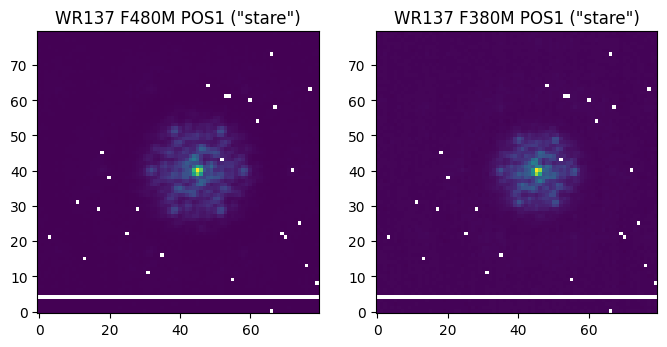

In [4]:
calints_targ_ep1 = [os.path.join(odir, 'jw01349006001_03102_00001_nis_calints.fits'),
                    os.path.join(odir, 'jw01349006001_03103_00001_nis_calints.fits'),
                   ]
print('WR137 data Epoch 1, July 15, 2022')
print('\n'.join(calints_targ_ep1))
               
data = []
for df in calints_targ_ep1:
    file = fits.open(df)
    #Uncomment to summarizes the contents of the FITS files
    #file.info()
    im = file[1].data
    print(im[0].shape)
    data.append(im[0])
    
   
f = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('WR137 F480M POS1 ("stare")')
plt.imshow(data[0], origin='lower')
plt.subplot(1, 2, 2)
plt.title('WR137 F380M POS1 ("stare")')
plt.imshow(data[1], origin='lower')


## Display Epoch 1 (July 15, 2022) HD228337 calibrated data at POS1 (dither pattern: stare)

HD228337 data Epoch 1, July 15, 2022
./pipeline_calibrated_data_epoch1_2/jw01349005001_03102_00001_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349005001_03103_00001_nis_calints.fits
(80, 80)
(80, 80)


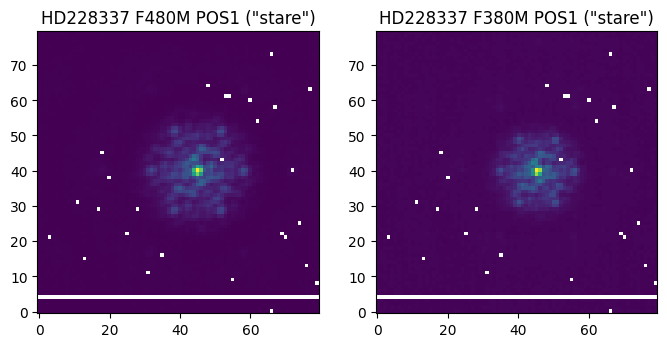

In [5]:
calints_calibrator_ep1 = [os.path.join(odir, 'jw01349005001_03102_00001_nis_calints.fits'),
                          os.path.join(odir, 'jw01349005001_03103_00001_nis_calints.fits'),
                         ]
print('HD228337 data Epoch 1, July 15, 2022')
print('\n'.join(calints_calibrator_ep1))
               
data = []
for df in calints_targ_ep1:
    file = fits.open(df)
    #Uncomment to summarizes the contents of the FITS files
    #file.info()
    im = file[1].data
    print(im[0].shape)
    data.append(im[0])
    
   
f = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('HD228337 F480M POS1 ("stare")')
plt.imshow(data[0], origin='lower')
plt.subplot(1, 2, 2)
plt.title('HD228337 F380M POS1 ("stare")')
plt.imshow(data[1], origin='lower')

## Display Epoch 2 (August 8, 2022) WR137 calibrated data at POS1, POS2, POS3, POS4 (dither pattern: 4-point)

WR137 data Epoch 2, August 8, 2022
./pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00001_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00002_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00003_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00004_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00001_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00002_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00003_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00004_nis_calints.fits
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)


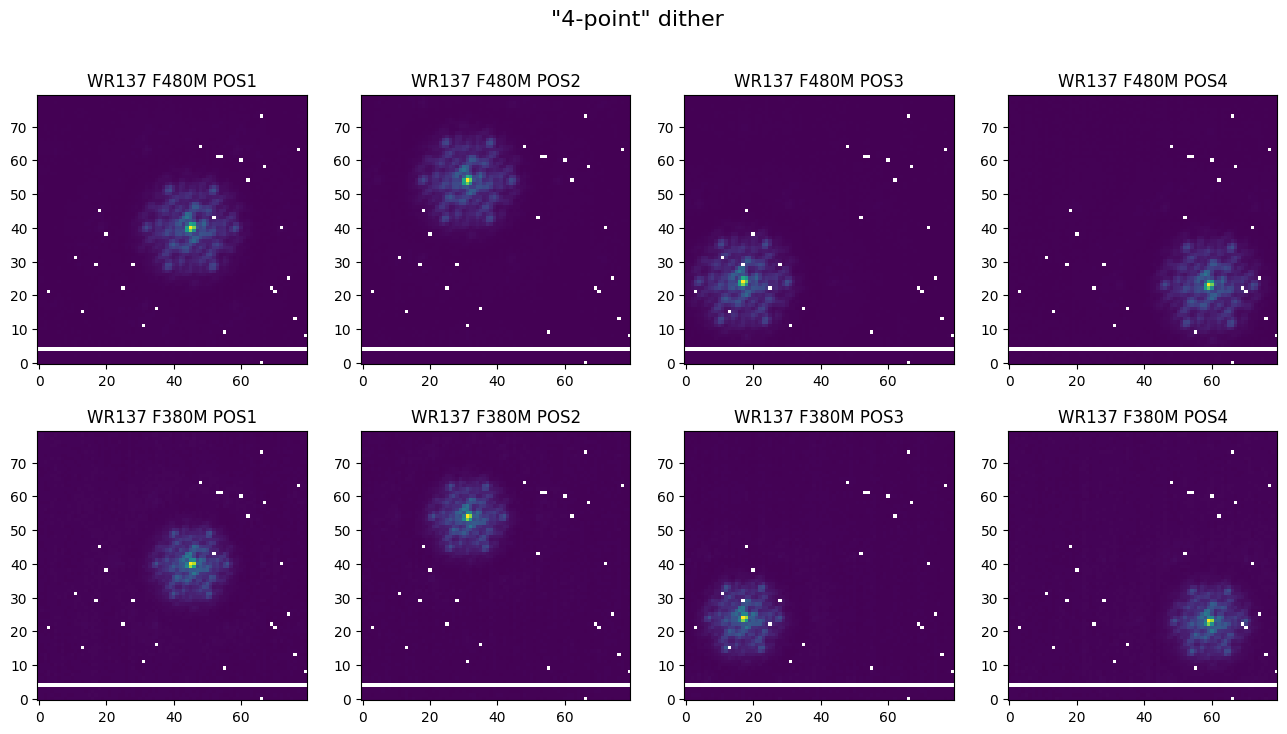

In [6]:
# First four files are NRM + F480M exposures at 4 dither positions.
# and the next four are NRM + F380M exposures at 4 dither positions.
calints_targ_ep2 = [os.path.join(odir,'jw01349053001_03102_00001_nis_calints.fits'),
                    os.path.join(odir,'jw01349053001_03102_00002_nis_calints.fits'),
                    os.path.join(odir,'jw01349053001_03102_00003_nis_calints.fits'),
                    os.path.join(odir,'jw01349053001_03102_00004_nis_calints.fits'),
                    os.path.join(odir,'jw01349053001_03104_00001_nis_calints.fits'),
                    os.path.join(odir,'jw01349053001_03104_00002_nis_calints.fits'),
                    os.path.join(odir,'jw01349053001_03104_00003_nis_calints.fits'),
                    os.path.join(odir,'jw01349053001_03104_00004_nis_calints.fits'),
                   ]

#calints_targ_ep2 = sorted(glob.glob(os.path.join(odir,'jw01349053001_03*_nis_calints.fits')))
print('WR137 data Epoch 2, August 8, 2022')
print('\n'.join(calints_targ_ep2))
               
data = []
for df in calints_targ_ep2:
    file = fits.open(df)
    #Uncomment to summarizes the contents of the FITS files
    #file.info()
    im = file[1].data
    print(im[0].shape)
    data.append(im[0])
    
    
f = plt.figure(figsize=(16, 8))
plt.suptitle('"4-point" dither', fontsize = 16)
plt.subplot(2, 4, 1)
plt.title('WR137 F480M POS1')
plt.imshow(data[0], origin='lower')
plt.subplot(2, 4, 2)
plt.title('WR137 F480M POS2')
plt.imshow(data[1], origin='lower')
plt.subplot(2, 4, 3)
plt.title('WR137 F480M POS3')
plt.imshow(data[2], origin='lower')
plt.subplot(2, 4, 4)
plt.title('WR137 F480M POS4')
plt.imshow(data[3], origin='lower') 
plt.subplot(2, 4, 5)
plt.title('WR137 F380M POS1')
plt.imshow(data[4], origin='lower')
plt.subplot(2, 4, 6)
plt.title('WR137 F380M POS2')
plt.imshow(data[5], origin='lower')
plt.subplot(2, 4, 7)
plt.title('WR137 F380M POS3')
plt.imshow(data[6], origin='lower')
plt.subplot(2, 4, 8)
plt.title('WR137 F380M POS4')
plt.imshow(data[7], origin='lower') 


## Display Epoch 2 (August 8, 2022) HD228337 calibrated data at POS1, POS2, POS3, POS4 (dither pattern: 4-point)

HD228337 data Epoch 2, August 8, 2022
./pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00001_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00002_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00003_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00004_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00001_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00002_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00003_nis_calints.fits
./pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00004_nis_calints.fits
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)


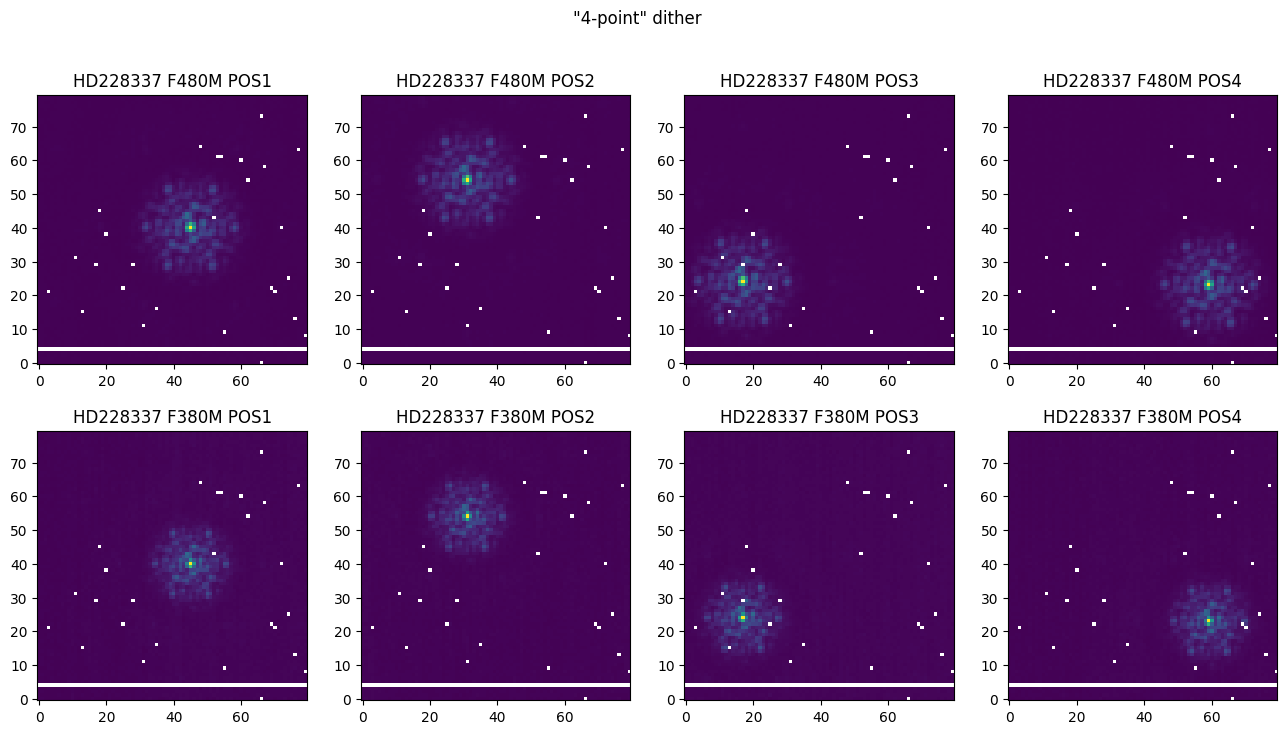

In [7]:
# First four files are NRM+F480M exposures at 4 dither positions.
# and the next four are NRM + F380M exposures at 4 dither positions.
calints_calibrator_ep2 = [os.path.join(odir,'jw01349054001_03102_00001_nis_calints.fits'), 
                      os.path.join(odir,'jw01349054001_03102_00002_nis_calints.fits'), 
                      os.path.join(odir,'jw01349054001_03102_00003_nis_calints.fits'), 
                      os.path.join(odir,'jw01349054001_03102_00004_nis_calints.fits'), 
                      os.path.join(odir,'jw01349054001_03104_00001_nis_calints.fits'), 
                      os.path.join(odir,'jw01349054001_03104_00002_nis_calints.fits'), 
                      os.path.join(odir,'jw01349054001_03104_00003_nis_calints.fits'), 
                      os.path.join(odir,'jw01349054001_03104_00004_nis_calints.fits'), 
                     ]

#calints_calibrator_ep2 = sorted(glob.glob(os.path.join(odir,'jw01349054001_03*_nis_calints.fits')))
print('HD228337 data Epoch 2, August 8, 2022')
print('\n'.join(calints_calibrator_ep2))
               
data = []
for df in calints_calibrator_ep2:
    file = fits.open(df)
    # Uncomment to summarizes the contents of the FITS files
    # file.info()
    im = file[1].data
    print(im[0].shape)
    data.append(im[0])
    
f = plt.figure(figsize=(16, 8))
plt.suptitle('"4-point" dither')
plt.subplot(2, 4, 1)
plt.title('HD228337 F480M POS1')
plt.imshow(data[0], origin='lower')
plt.subplot(2, 4, 2)
plt.title('HD228337 F480M POS2')
plt.imshow(data[1], origin='lower')
plt.subplot(2, 4, 3)
plt.title('HD228337 F480M POS3')
plt.imshow(data[2], origin='lower')
plt.subplot(2, 4, 4)
plt.title('HD228337 F480M POS4')
plt.imshow(data[3], origin='lower') 
plt.subplot(2, 4, 5)
plt.title('HD228337 F380M POS1')
plt.imshow(data[4], origin='lower')
plt.subplot(2, 4, 6)
plt.title('HD228337 F380M POS2')
plt.imshow(data[5], origin='lower')
plt.subplot(2, 4, 7)
plt.title('HD228337 F380M POS3')
plt.imshow(data[6], origin='lower')
plt.subplot(2, 4, 8)
plt.title('HD228337 F380M POS4')
plt.imshow(data[7], origin='lower') 


## Examine the output products of the ami_analyze step

Analytical model is created and interferometric observables are calculated for each integration of the data. The amimulti-oi file contains per-integration interferometric observables and the ami-oi file is averaged over integrations. The amilg product is a FITS file containing the cropped data, model, residuals and the best-fit model parameters. 

The ami_normalize step produces an aminorm-oi product, which is also contained in a AmiOIModel. The model conforms to the standard defined in OIFITS2 standard.

In the per-integration amimulti-oi products the “OI_ARRAY”, “OI_T3”, “OI_VIS”, and “OI_VIS2” extensions each contain 2D data columns whose second dimension equals the number of integrations. In the averaged ami-oi product and normalized aminorm-oi products, these columns have a single dimension whose length is independent of the number of integrations. (see https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#ami-data-ami-oi-amimulti-oi-amilg-and-aminorm-oi)

### WR137 FITS files containing the cropped data, model, residuals and the best-fit model parameters. 

### Epoch 1, July 15, 2022

In [8]:
amilg_targ_ep1 = sorted(glob.glob(os.path.join(odir, 'jw01349006*amilg.fits')))
amilg_targ_ep1

['./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349006001_03103_00001_nis_amilg.fits']

### Epoch 2, August 8, 2022

In [9]:
amilg_targ_ep2 = sorted(glob.glob(os.path.join(odir, 'jw01349053*amilg.fits')))
amilg_targ_ep2

['./pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00001_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00002_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00003_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00004_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00001_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00002_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00003_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00004_nis_amilg.fits']

### Calibrator HD228337 FITS files containing the cropped data, model, residuals and the best-fit model parameters.

### Epoch 1, July 15, 2022

In [10]:
amilg_calibrator_ep1 = sorted(glob.glob(os.path.join(odir, 'jw01349005*amilg.fits')))
amilg_calibrator_ep1

['./pipeline_calibrated_data_epoch1_2/jw01349005001_03102_00001_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349005001_03103_00001_nis_amilg.fits']

### Epoch 2, August 8, 2022

In [11]:
amilg_calibrator_ep2 = sorted(glob.glob(os.path.join(odir, 'jw01349054*amilg.fits')))
amilg_calibrator_ep2

['./pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00001_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00002_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00003_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00004_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00001_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00002_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00003_nis_amilg.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00004_nis_amilg.fits']

### We will look at one amilg product for the target WR137 and one amilg product for the calibrator.

WR137 amilg product
Filename: ./pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00001_nis_amilg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     342   ()      
  1  CTRD          1 ImageHDU        10   (69, 69, 400)   float32   
  2  N_CTRD        1 ImageHDU        10   (69, 69, 400)   float32   
  3  FIT           1 ImageHDU        10   (69, 69, 400)   float32   
  4  N_FIT         1 ImageHDU        10   (69, 69, 400)   float32   
  5  RESID         1 ImageHDU        10   (69, 69, 400)   float32   
  6  N_RESID       1 ImageHDU        10   (69, 69, 400)   float32   
  7  SOLNS         1 BinTableHDU     13   400R x 1C   [44D]   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [7280B]   
HD228337 amilg product
Filename: ./pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00001_nis_amilg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     342   ()      
  1  CTRD        

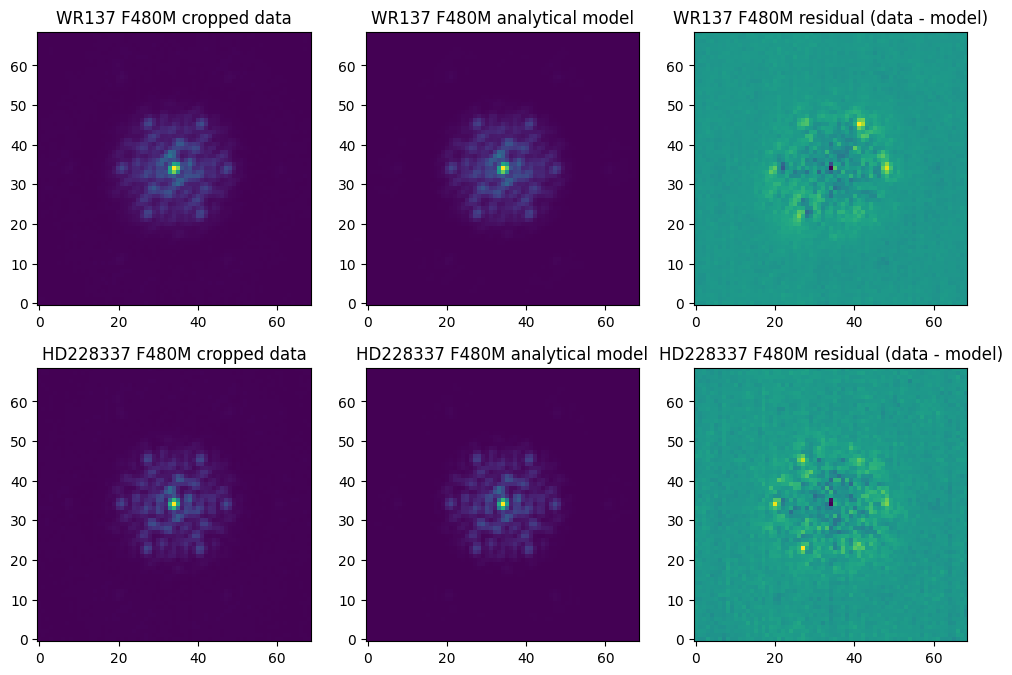

In [13]:
t = fits.open(amilg_targ_ep2[0])
c = fits.open(amilg_calibrator_ep2[0])
print('WR137 amilg product')
t.info()
print('HD228337 amilg product')
c.info()

print("""
        The _amilg.fits output file contains the cropped and cleaned data, model, and residuals (data - model) 
        as well as the parameters of the best-fit LG model. It contains the following extensions:
        CTRD: A 3D image of the centered, cropped data.
        N_CTRD: A 3D image CTRD normalized by data peak. 
        FIT: 3D image of the best-fit model.
        N_FIT: A 3D image of FIT normalized by data peak.
        RESID: A 3D image of the fit residuals.
        N_RESID: A 3D image of RESID normalized by data peak.
        SOLNS: A table of fringe coefficients.
        ADSF: The data model meta data.
        
        Reference: https://jwst-pipeline.readthedocs.io/en/latest/jwst/ami_analyze/description.html#lg-model-parameters
        """)


f = plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title('WR137 F480M cropped data')
plt.imshow((t[2].data)[0], origin='lower')
plt.subplot(2, 3, 2)
plt.title('WR137 F480M analytical model')
plt.imshow((t[4].data)[0], origin='lower')
plt.subplot(2, 3, 3)
plt.title('WR137 F480M residual (data - model)')
plt.imshow((t[6].data)[0], origin='lower')
plt.subplot(2, 3, 4)
plt.title('HD228337 F480M cropped data')
plt.imshow((c[2].data)[0], origin='lower') 
plt.subplot(2, 3, 5)
plt.title('HD228337 F480M analytical model')
plt.imshow((c[4].data)[0], origin='lower')
plt.subplot(2, 3, 6)
plt.title('HD228337 F480M residual (data - model)')
plt.imshow((c[6].data)[0], origin='lower')


## oifits files for the target and calibrator

OIFITS is the standard data exchange format for Optical Interferometry.  It is based on the Flexible Image Transport System (FITS).  OIFITS files include data tables for storing interferometric observables, including squared visibilities and closure phases. 

The oifits files have the following extensions
```
OI_ARRAY: AMI subaperture information
OI_TARGET: Target properties
OI_T3: Table of closure amplitudes, phases
OI_VIS: Table of visibility (fringe) amplitudes, phases
OI_VIS2: Table of squared visibility (fringe) amplitudes
OI_WAVELENGTH: Filter information
ADSF: The data model meta data.
```
Reference: https://jwst-pipeline.readthedocs.io/en/latest/jwst/ami_analyze/description.html#interferometric-observables

### WR137 oifits files

### Epoch 1, July 15, 2022

In [17]:
oifits_targ_ep1 = sorted(glob.glob(os.path.join(odir, 'jw01349006*nis_ami-oi.fits')))
oifits_targ_ep1

['./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349006001_03103_00001_nis_ami-oi.fits']

In [18]:
multioifits_targ_ep1 = sorted(glob.glob(os.path.join(odir, 'jw01349006*nis_amimulti-oi.fits')))
multioifits_targ_ep1

['./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349006001_03103_00001_nis_amimulti-oi.fits']

In [19]:
# Display raw oifits file information
fits.info(oifits_targ_ep1[0])
fits.info(multioifits_targ_ep1[0])

Filename: ./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_ami-oi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     344   ()      
  1  OI_ARRAY      1 BinTableHDU     38   7R x 10C   [16A, 16A, I, E, 3D, D, 6A, 2D, D, D]   
  2  OI_TARGET     1 BinTableHDU     45   1R x 17C   [I, 16A, D, D, E, D, D, D, 8A, 8A, D, D, D, D, E, E, 16A]   
  3  OI_T3         1 BinTableHDU     43   35R x 14C   [I, D, D, D, D, D, D, D, D, D, D, D, 3I, L]   
  4  OI_VIS        1 BinTableHDU     39   21R x 12C   [I, D, D, D, D, D, D, D, D, D, 2I, L]   
  5  OI_VIS2       1 BinTableHDU     35   21R x 10C   [I, D, D, D, D, D, D, D, 2I, L]   
  6  OI_WAVELENGTH    1 BinTableHDU     16   1R x 2C   [E, E]   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [11204B]   
Filename: ./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_amimulti-oi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 P

### Epoch 2, August 8, 2022

In [20]:
oifits_targ_ep2 = sorted(glob.glob(os.path.join(odir, 'jw01349053*nis_ami-oi.fits')))
oifits_targ_ep2

['./pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00002_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00003_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00004_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00002_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00003_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00004_nis_ami-oi.fits']

In [21]:
multioifits_targ_ep2 = sorted(glob.glob(os.path.join(odir, 'jw01349053*nis_amimulti-oi.fits')))
multioifits_targ_ep2

['./pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00001_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00002_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00003_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00004_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00001_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00002_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00003_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00004_nis_amimulti-oi.fits']

### calibrator HD228337 oifits files

### Epoch 1, July 15, 2022

In [22]:
oifits_calibrator_ep1 = sorted(glob.glob(os.path.join(odir, 'jw01349005*nis_ami-oi.fits')))
oifits_calibrator_ep1

['./pipeline_calibrated_data_epoch1_2/jw01349005001_03102_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349005001_03103_00001_nis_ami-oi.fits']

In [23]:
multioifits_calibrator_ep1 = sorted(glob.glob(os.path.join(odir, 'jw01349005*nis_amimulti-oi.fits')))
multioifits_calibrator_ep1

['./pipeline_calibrated_data_epoch1_2/jw01349005001_03102_00001_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349005001_03103_00001_nis_amimulti-oi.fits']

### Epoch 2, August 8, 2022

In [24]:
oifits_calibrator_ep2 = sorted(glob.glob(os.path.join(odir, 'jw01349054*nis_ami-oi.fits')))
oifits_calibrator_ep2

['./pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00002_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00003_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00004_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00002_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00003_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00004_nis_ami-oi.fits']

In [25]:
multioifits_calibrator_ep2 = sorted(glob.glob(os.path.join(odir, 'jw01349054*nis_amimulti-oi.fits')))
multioifits_calibrator_ep2

['./pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00001_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00002_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00003_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00004_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00001_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00002_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00003_nis_amimulti-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00004_nis_amimulti-oi.fits']

### oifits files from both epoch 1 and epoch 2

In [26]:
oifits_targ = oifits_targ_ep1 + oifits_targ_ep2
oifits_targ

['./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349006001_03103_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00002_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00003_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00004_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00002_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00003_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00004_nis_ami-oi.fits']

In [27]:
oifits_calibrator = oifits_calibrator_ep1 + oifits_calibrator_ep2
oifits_calibrator

['./pipeline_calibrated_data_epoch1_2/jw01349005001_03102_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349005001_03103_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00002_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00003_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03102_00004_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00001_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00002_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00003_nis_ami-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349054001_03104_00004_nis_ami-oi.fits']

### Run ami_normalize step of the AMI3 pipeline on the raw oifits files to calibrate target observables with calibrator observables

In [28]:
def normalize_oifits(targ_oi,cal_oi,calib_oi):
    """
    calibrate closure phases and square visibilities of target with those of the calibrator."

    Parameters
    ----------
    input
        targ_oi: target oifits file
        cal_oi: calibrator oifits file
        calib_oi: name of calibrated (normalized) oifits file

    Returns:
        calibrated oifits file
    -------
    """
    normalize = AmiNormalizeStep()
    normalize.output_dir = odir
    normalize.output_file = calib_oi
    normalize.save_results = True
    normmodel = normalize.run(targ_oi,cal_oi) # target oifits file, calibrator oifits file

In [29]:
# Construct output file names for calibrated oifits files
calib_oifiles_rootname = [os.path.basename(oifits_targ[0].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[0].replace('_ami-oi.fits','')),
                 os.path.basename(oifits_targ[1].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[1].replace('_ami-oi.fits','')),
                 os.path.basename(oifits_targ[2].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[2].replace('_ami-oi.fits','')),
                 os.path.basename(oifits_targ[3].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[3].replace('_ami-oi.fits','')),
       	       	 os.path.basename(oifits_targ[4].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[4].replace('_ami-oi.fits','')),
       	       	 os.path.basename(oifits_targ[5].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[5].replace('_ami-oi.fits','')),
       	       	 os.path.basename(oifits_targ[6].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[6].replace('_ami-oi.fits','')),
       	       	 os.path.basename(oifits_targ[7].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[7].replace('_ami-oi.fits','')),
                 os.path.basename(oifits_targ[8].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[8].replace('_ami-oi.fits','')),
                 os.path.basename(oifits_targ[9].replace('_ami-oi.fits',''))+'_norm_'+os.path.basename(oifits_calibrator[9].replace('_ami-oi.fits','')),
                ]
# Calibrate target observables with calibrator observables
# calibrate observation 006 exposures with observation 005 exposures, calibrate observation 053 with observation 054 exposures
# with the same dither and filter combination.
normalize_oifits(oifits_targ[0], oifits_calibrator[0],calib_oifiles_rootname[0])
normalize_oifits(oifits_targ[1], oifits_calibrator[1],calib_oifiles_rootname[1])
normalize_oifits(oifits_targ[2], oifits_calibrator[2],calib_oifiles_rootname[2])
normalize_oifits(oifits_targ[3], oifits_calibrator[3],calib_oifiles_rootname[3])
normalize_oifits(oifits_targ[4], oifits_calibrator[4],calib_oifiles_rootname[4])
normalize_oifits(oifits_targ[5], oifits_calibrator[5],calib_oifiles_rootname[5])
normalize_oifits(oifits_targ[6], oifits_calibrator[6],calib_oifiles_rootname[6])
normalize_oifits(oifits_targ[7], oifits_calibrator[7],calib_oifiles_rootname[7])
normalize_oifits(oifits_targ[8], oifits_calibrator[6],calib_oifiles_rootname[8])
normalize_oifits(oifits_targ[9], oifits_calibrator[7],calib_oifiles_rootname[9])

2024-08-07 18:06:20,701 - stpipe.AmiNormalizeStep - INFO - AmiNormalizeStep instance created.
2024-08-07 18:06:20,799 - stpipe.AmiNormalizeStep - INFO - Step AmiNormalizeStep running with args ('./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_ami-oi.fits', './pipeline_calibrated_data_epoch1_2/jw01349005001_03102_00001_nis_ami-oi.fits').
2024-08-07 18:06:20,800 - stpipe.AmiNormalizeStep - INFO - Step AmiNormalizeStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /Users/thatte/niriss/dat_pyinthesky_asof_20210720/jdat_notebooks/niriss_ami_binary/wrdusters/jw01349006001_03102_00001_nis_norm_jw01349005001_03102_00001_nis
  output_dir: ./pipeline_calibrated_data_epoch1_2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: aminorm-oi
  search_output_file: True
  input_dir: ''
2024-08-07 18:06:23,575 - stpipe.AmiNormalizeStep - INFO - Saved model in ./pipeline_calibrated_data_epoch1_2/jw0134900

### Output of AmiNormalizeStep: Calibrated observables of target WR137

In [31]:
calib_oifiles = sorted(glob.glob(os.path.join(odir,'jw*nis_aminorm-oi.fits')))
calib_oifiles

['./pipeline_calibrated_data_epoch1_2/jw01349006001_03102_00001_nis_norm_jw01349005001_03102_00001_nis_aminorm-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349006001_03103_00001_nis_norm_jw01349005001_03103_00001_nis_aminorm-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00001_nis_norm_jw01349054001_03102_00001_nis_aminorm-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00002_nis_norm_jw01349054001_03102_00002_nis_aminorm-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00003_nis_norm_jw01349054001_03102_00003_nis_aminorm-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03102_00004_nis_norm_jw01349054001_03102_00004_nis_aminorm-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00001_nis_norm_jw01349054001_03104_00001_nis_aminorm-oi.fits',
 './pipeline_calibrated_data_epoch1_2/jw01349053001_03104_00002_nis_norm_jw01349054001_03104_00002_nis_aminorm-oi.fits',
 './pipeline_calibrated_data_epo

## The calibrated oifits files are used for image reconstruction

<div class="alert alert-block alert-info">
### NOTE: THIS NOTEBOOK IS NOT USING FRAME SELECTION SINCE IT IS WORK IN PROGRESS.